# Heart Attack Prediction

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

import warnings
warnings.filterwarnings("ignore")

## Table of Contents:
* [Exploratory Data Analysis](#first-bullet)
* [Data Preprocessing](#second-bullet)
* [Model Building](#third-bullet)
    * [Decision Trees](#sixth-bullet)
    * [Random Forest](#seventh-bullet)
    * [Boosting](#eigth-bullet)
        * [AdaBoost](#nine_bullet)
        * [Gradient Boosting](#ten-bullet)
    * [XGBoost](#eleven-bullet)
* [Conclusions](#last-bullet)

***

In this section, different **Tree Based Models** for classification will be performed upon the **Heart Disease Dataset**, which contains several continuous and categorical variables that can explain whether or not a patient has a heart disease. The [original dataset](https://archive.ics.uci.edu/ml/datasets/heart+disease) provided in the Machine Learning Repository contains 76 attributes, however here 14 attributes will be used, which are considered the most relevant predictors for the disease. Besides, missing data is already handled (either by dropping certain rows or by means of imputation techniques) and the response variable **hd** is binarized to **0-1** instead of having **4** levels as the original dataset has.

After all modifications, the used [dataset](https://www.kaggle.com/ronitf/heart-disease-uci) contains 303 rows and 14 attributes, which are: 
+ __age__
+ __sex__
+ __cp__, chest pain
+ __restbp__, resting blood pressure (in mmHg)
+ __chol__, serum cholesterol in mg/dl
+ __fbs__, fasting blood sugar
+ __restecg__ restingelectrocardiographic results
+ __thalach__, maxumum heart rate achieved
+ __exang__, exercise induced angina
+ __oldpeak__, ST depression induced by exercise relative to rest
+ __slope__, the slope of the peak exercise ST segment
+ __ca__, number of major vessels (0-3) colored by floroscopy
+ __thal__, thalium heart scan
+ __hd__, diagnosis of hear disease (response variable)

In [2]:
cols = 'age sex cp restbp chol fbs restecg thalach exang oldpeak slope ca thal hd'.split()
df = pd.read_csv('./heart.csv', names=cols, skiprows=1)
df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
# Data shape 
print('Rows=',df.shape[0], ', Columns=',df.shape[1])

# Check for missing values in our data
print('Missing values: {}'.format(df.isnull().sum().sum()))

Rows= 303 , Columns= 14
Missing values: 0


## Explanatory Data Analysis (EDA)<a class="anchor" id="first-bullet"></a>

The first step before the model building is performing EDA techniques to understand and summarize the Heart Disease Dataset. 

Our dataset contains more than twice males than females. By analysing the correlations between features, apparently, there is no significant linear correlation between continuous variables as it can be appreciated in the heatmap below. However, the heatmap matrix suggests that there might be some positive correlation between the heart disease **hd** and the chest pain **cp** and the maximum heart rate achieved **thalach**. Contrarily,the correlation heatmap matrix indicates a negative correlation between our target variable **hd** and the number of major vessels **ca**, the exercise induced angina **exang** and the ST depression induced by exercise relative to rest **oldpeak**. 
It is intuitive to first think that elder people might have higher chances of heart disease, but according to the distribution plot of age with respect to target variable, it is ambiguous that there exist a slight positive correlation. All these relations motioned can also be be noticed in the pair-plot distributions of selected features against heart disease. 

         count        mean        std    min    25%    50%    75%    max
age      303.0   54.366337   9.082101   29.0   47.5   55.0   61.0   77.0
sex      303.0    0.683168   0.466011    0.0    0.0    1.0    1.0    1.0
cp       303.0    0.966997   1.032052    0.0    0.0    1.0    2.0    3.0
restbp   303.0  131.623762  17.538143   94.0  120.0  130.0  140.0  200.0
chol     303.0  246.264026  51.830751  126.0  211.0  240.0  274.5  564.0
fbs      303.0    0.148515   0.356198    0.0    0.0    0.0    0.0    1.0
restecg  303.0    0.528053   0.525860    0.0    0.0    1.0    1.0    2.0
thalach  303.0  149.646865  22.905161   71.0  133.5  153.0  166.0  202.0
exang    303.0    0.326733   0.469794    0.0    0.0    0.0    1.0    1.0
oldpeak  303.0    1.039604   1.161075    0.0    0.0    0.8    1.6    6.2
slope    303.0    1.399340   0.616226    0.0    1.0    1.0    2.0    2.0
ca       303.0    0.729373   1.022606    0.0    0.0    0.0    1.0    4.0
thal     303.0    2.313531   0.612277    0.0    2.0

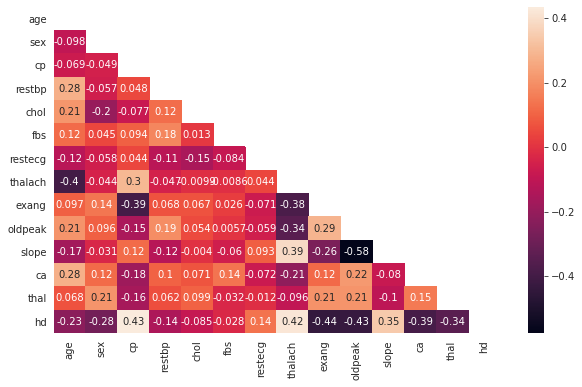

In [4]:
# Summary statistics of data
print(df.describe().transpose())

# Multivariate analysis

df_corr = df.corr()
mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 6))
    ax = sns.heatmap(df_corr, 
            xticklabels = df_corr.columns.values,
            yticklabels = df_corr.columns.values,
            annot = True, mask=mask);

#plt.figure(figsize=(14, 14))
#sns.pairplot(df, diag_kind='kde', hue='hd') --> Selected features to do a subplot for visualization

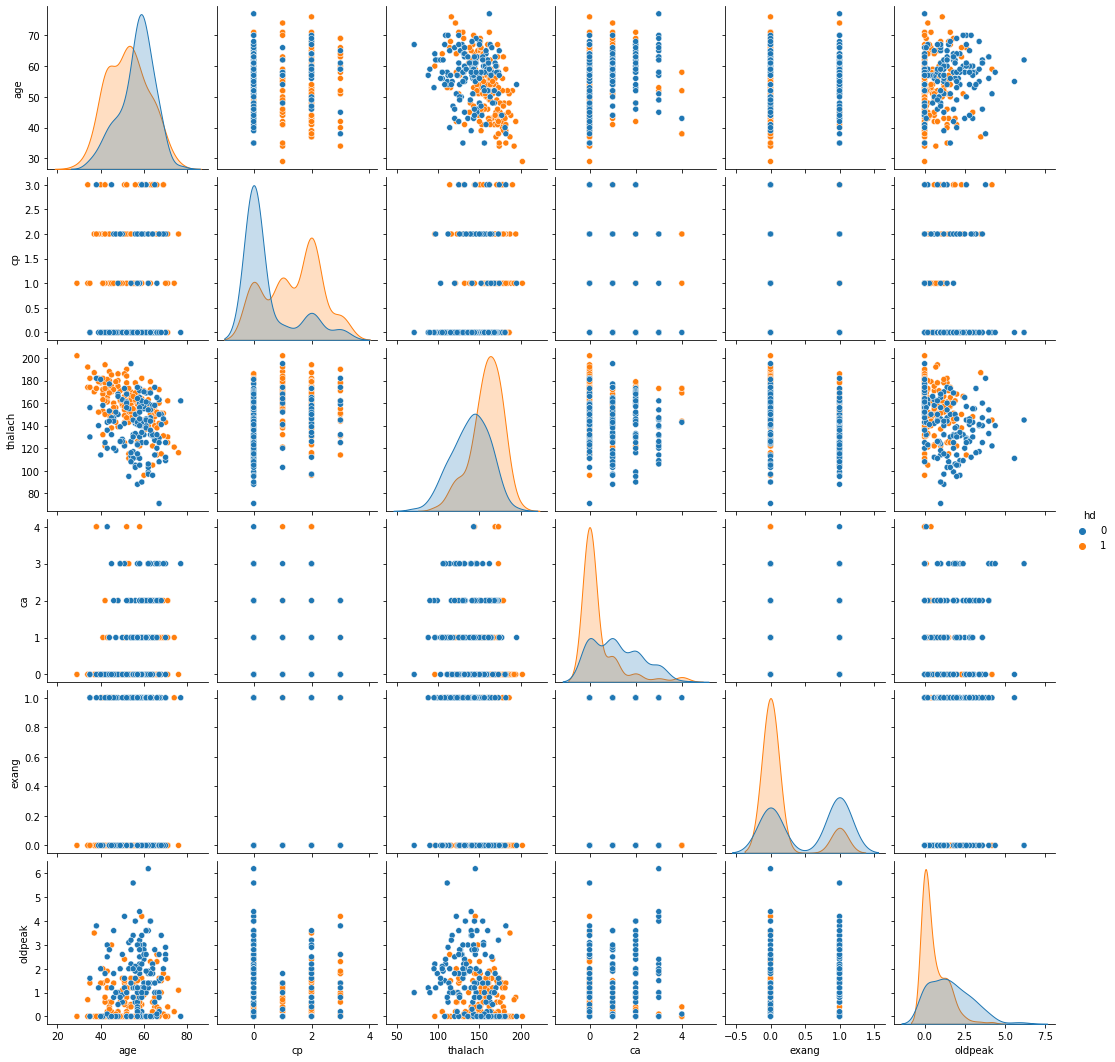

In [5]:
sns.pairplot(df, vars=['age','cp','thalach','ca','exang','oldpeak'], diag_kind='kde', hue='hd')

By analysing the target variable **hd** it can be appreciated in Figure 1 that the dataset contains a similar number of observations for both target categories. Therefore, the target variable is balanced. This is an important fact to take into account when splitting the dataset into train and test sets, since if unbalance is present the split has to be stratified in order to distribute the observations evenly between sets, otherwise problems would arise when performing machine learning models. 

Furthermore, this information is also relevant when it comes to decide which score to be used for evaluating the performance of the models. If imbalance is present, the accuracy score is not a good option because a high score will be biased by simply predicting that all observations belong to the majority class. 

Text(0, 0.5, '')

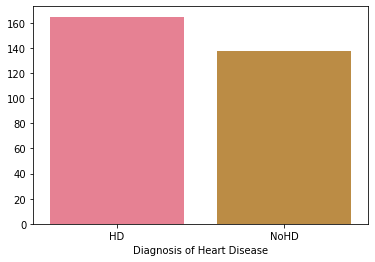

In [6]:
plt.figure(figsize = (6, 4))
sns.set_palette("husl", 8)
df_o = df.copy()
df_o['hd'] = df_o['hd'].map({0:'NoHD', 1:'HD'})
sns.countplot(data = df_o, x = 'hd')
plt.xlabel('Diagnosis of Heart Disease')
plt.ylabel('')

## Data Preprocessing<a class="anchor" id="second-bullet"></a>

When inspecting the data types of the dataframe, some columns, such as **cp** and **slope**, have a numeric data type instead of being considered categorical. These columns contain an *int* data type although they should not to be used as integers but as different levels of a category (e.g. in **slope**, 1, 2, 3 refer respectively to *unslopping*, *flat* and *downslopping*, not ordinal integers).

+ __sex__
    + 0 = female
    + 1 = male
+ __cp__, chest pain
    + 1 = typical angina
    + 2 = atypical angina
    + 3 = non-anginal pain
    + 4 = asymptomatic
+ __fbs__, fasting blood sugar
    + 0 $\to$ >=120 mg/dl
    + 1 $\to$ <120 mg/dl
+ __restecg__ restingelectrocardiographic results
    + 1 = normal
    + 2 = having ST-T wave abnormality
    + 3 = showing probable or definite left ventricular hypertrophy
+ __exang__, exercise induced angina
    + 0 = no
    + 1 = yes
+ __slope__, the slope of the peak exercise ST segment
    + 1 = unslopping
    + 2 = flat
    + 3 = downslopping
+ __thal__, thalium heart scan
    + 3 = normal
    + 6 = fixed defect
    + 7 = reversible defect
    

The aforementioned columns have to be handled because the sklearn models that are going to be implemented do not natively support categorical data. Therefore, the columns with more than 2 levels have to be converted into multiple columns of binary values, named One-Hot Encoding

"Dummy encoding could be also considered, which instead of generating $k$ variables from a column with $k$ levels, it generates $k-1$ variables, enclosing one level in the intercept, thus reducing the co-linearity that may arise between new variables. Since tree based models follow non-parametric approaches, no assumptions on relationships are made".

One Hot Encoding can be performed both with sklearn `OneHotEncoder` or pandas `get_dummies()`. Since further feature engineering with sklearn and pipelines are not going to be used, it is preferred to used the later method, which in some way is simpler and stores the output in a dataframe rather than in an array.

In [7]:
df_encoded = pd.get_dummies(df, columns = ['cp', 'restecg', 'slope', 'thal'])
df_encoded.head(3)

,age,sex,restbp,chol,fbs,thalach,exang,oldpeak,ca,hd,...,restecg_0,restecg_1,restecg_2,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2,thal_3
0,63,1,145,233,1,150,0,2.3,0,1,...,1,0,0,1,0,0,0,1,0,0
1,37,1,130,250,0,187,0,3.5,0,1,...,0,1,0,1,0,0,0,0,1,0
2,41,0,130,204,0,172,0,1.4,0,1,...,1,0,0,0,0,1,0,0,1,0


In many machine learning models, further preprocessing typically takes place, such as feature selection and feature scaling. On this dataset,
feature scaling is not considered since tree based models do not make assumptions on relationships and distributions, such as co-linearity, normality or homoscedasticity.
Nonetheless, often data sets contains high amount of features including non-informative ones. Our goal is to create a model that only includes those features more important to predict our target value. This has a significant impact in reducing the variance of our model, and thus the over-fitting, it also creates a more simple model to interpret, and it reduces the computational cost (run time) of training a model. The process of identifying only the most relevant features is called feature selection. 
Tree-based methods are often used for this propose due to the fact that the these methods naturally rank by how well they improve the purity of the node. This mean decrease in impurity over all trees (called gini index, which tells us what is the probability of misclassifying an observation). Nodes with the greatest decrease in gini index happen at the start of the trees, while notes with the least decrease occur at the end of trees. Thus, by pruning trees below a particular node, we can create a subset of the most important features. We will use this technique when building some of our models in order to try to simplify them. 

***

## Model Building<a class="anchor" id="third-bullet"></a>

Once all the necessary preprocessing is done, the dataset is split into train and test sets using `train_test_split` from sklearn. The conventional notation on Machine Leaning is used, in which `X` represents the explanatory variables and `y` the target variable. Since the complete dataset is not quite big (303 observations), it is split into 20% test set and 80% training set, resulting in 242 observations on the former and 61 on the later. 

In [8]:
X_data = df_encoded.drop('hd', axis=1)
y_data = df_encoded[['hd']]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=1717)

In [9]:
print(f'Rows Train Set: {y_train.shape[0]}')
print(f'Rows Test Set: {y_test.shape[0]}')

Rows Train Set: 242
Rows Test Set: 61


***

### Decision Trees<a class="anchor" id="sixth-bullet"></a>

In [10]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

The first model that is built corresponds to a **Classification Tree** using `DecisionTreeClassifier` from `sklearn.tree`. Classification Trees are an
exceptionally useful machine learning method when it is needed to know how the decisions that are being made.

Firstly, a Classification Tree is built without specifying any parameter.

In [11]:
clf_dt = DecisionTreeClassifier(random_state=1717)
clf_dt.fit(X_train,y_train)

y_pred = clf_dt.predict(X_test)

print("Train set accuracy: {:.3f}".format(clf_dt.score(X_train, y_train)))
print("Test set accuracy: {:.3f}".format(clf_dt.score(X_test, y_test)))

Train set accuracy: 1.000
Test set accuracy: 0.639


We obtain a tree that yields 100\% training accuracy and 63.9\% test accuracy, consequently meaning that the model has overfit the training data. For this reason, pruning needs to be applied to the model in order to make it perform better with unseen data.

Overfitting in Decision Trees can be reduced by optimizing parameters that are designed to reduce it, such as `max_depth` and `min_samples` ---which respectively control the maximum depth of a tree and minimum number of observations a terminal leaf can have---, thereby avoiding trees to grow in the direction towards isolating unique observations and eventually overfitting the data. These parameters can be optimized by using Cross Validation and Grid Search. Nevertheless, cost complexity pruning is also an effective way to find the best tree and can simplify the process of finding a smaller tree.

Pruning a decision tree consists on finding the right value for the pruning parameter `alpha`

"As a reminder `alpha` is a complexity parameter that is taken into consideration in order to penalize large trees. It influences the Cost Complexity Function $C_{\alpha}(T) = R(T) + \alpha |T|$,  which quantifies the capacity of a tree to predict accurately the data in terms of missclassification rate} which controls the extend on how much pruning happens". 

In the Figure 2 it is appreciated that as the value of alpha increases, both the number of nodes and the depth of the tree decreases. That reduction stems from the fact that the tree gradually gets smaller until it reaches a point where the tree corresponds only to the root node.

In [12]:
# Determine values for alpha
path = clf_dt.cost_complexity_pruning_path(X_train, y_train) 
ccp_alphas = path.ccp_alphas
ccp_alphas, impurities = path.ccp_alphas, path.impurities

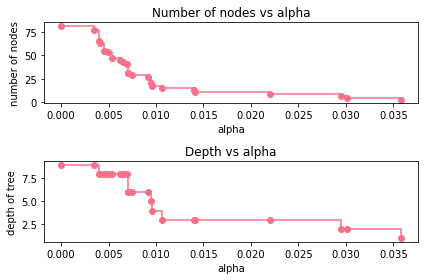

In [13]:
# PLOT 1: Effect of alpha on number of nodes and depth 
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
    
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1] # ommit maximum value

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

By means of graphing the accuracy of the trees using the Training Dataset and the Testing Dataset as a function of `alpha` the best value for the parameter can be found. When `alpha` is set to zero, the tree overfits, leading to a 100\% training accuracy and 64\% testing accuracy. As `alpha` increases, more pruning takes place, thus creating a decision tree that generalizes better. Here, setting `alpha=0.023` maximizes the test accuracy.

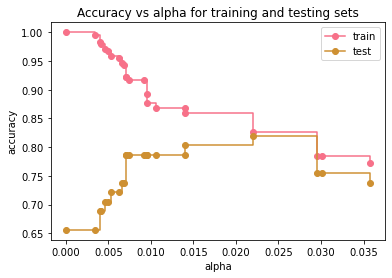

In [14]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()

Figure 3 only has illustrative purposes since values on the parameters cannot be optimized from the test set. For this reason, cross validation is used to find the best value for `alpha` that generates trees flexible enough to classify accurately unseen data. To that end, 5-fold cross validation is performed where the average accuracy and average standard deviation are stored for each value of `alpha`.

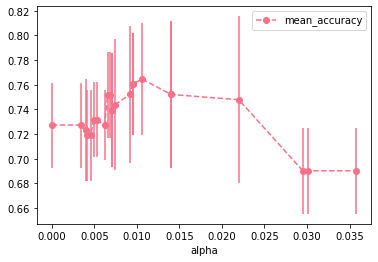

In [15]:
## Using Cross Validation to find alpha
alpha_values = []

for a in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=a)
    scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
    alpha_values.append([a, np.mean(scores), np.std(scores)])
    
alpha_results = pd.DataFrame(alpha_values, columns = ['alpha', 'mean_accuracy', 'std'])
alpha_results.plot(x='alpha',
                  y='mean_accuracy',
                  yerr='std',
                  marker='o',
                  linestyle='--')

In [16]:
alpha_results.iloc[alpha_results['mean_accuracy'].argmax()]
ideal_ccp_alpha = float(alpha_results['alpha'].iloc[alpha_results['mean_accuracy'].argmax()])

By using the `alpha` that generated the maximum mean accuracy a Decision Tree Classifier pruned with this value it is built. 

In [17]:
clf_dt_pruned = DecisionTreeClassifier(random_state=1717, ccp_alpha=ideal_ccp_alpha)
clf_dt_pruned.fit(X_train, y_train)

y_pred = clf_dt_pruned.predict(X_test)

print("Test set accuracy: {:.3f}".format(clf_dt_pruned.score(X_test, y_test)))

Test set accuracy: 0.787


After pruning, the test set accuracy has increased from 63.9\% to 78.7\%, which can be considered a significant improvement. By representing the classification of the test observations in a confusion matrix, it can be seen that of the 22 + 8 = 30 people that did not have HD, 22 (73\%) were correctly classified. And of 5+26=31 people that have the disease, 26 (83\%) were corretly classified.

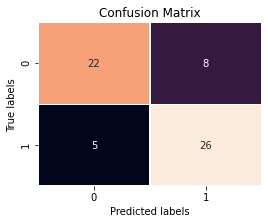

In [18]:
plt.figure(figsize = (4, 3))
cf_dt_matrix = confusion_matrix(y_test, y_pred)

ax=plt.subplot()
sns.heatmap(cf_dt_matrix, annot=True, linecolor='white', linewidths=0.5, cbar = False)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

The final representation of the optimized tree is illustrated in the following figure. It corresponds to a tree of depth 4 ---in contrast to depth 10 of the complete tree previously built--- that considers the variables **thal**, **cp**, **oldpeack**, **ca** and **thalach** as the optimal features to split the data and obtain the maximum information gain. Among these variables,  thalium heart scan **thal** is the variable that splits the 242 samples of the root into 131 and 111 samples in the new nodes, therefore it can be considered the most important variable to determine the presence of heart disease in the decision tree.

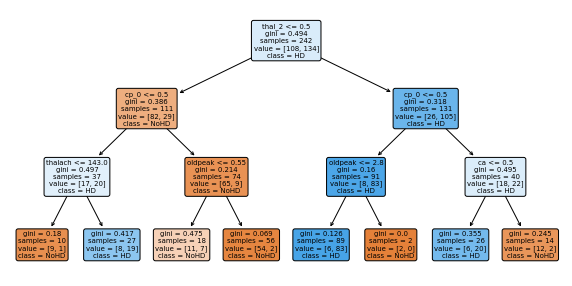

In [19]:
plt.figure(figsize=(10, 5))
plot_tree(clf_dt_pruned,
         filled=True,
         rounded=True,
         class_names=["NoHD", "HD"],
         feature_names=X_data.columns);

***
### Random Forest<a class="anchor" id="seventh-bullet"></a>

In [20]:
from sklearn.ensemble import RandomForestClassifier

Random forest is a tree-based algorithm composed of many decision trees where their outputs are combined to enhance the performance of a given model. Here, a random forest classifier is going to be implemented using `RandomForestClassifier` from *sklearn.ensemble*. As done previously, we fit a random forest without specifying any parameter

"By default, the model will consider 100 estimators, use the *gini* index as split criterion, minimum samples for split and for leaves at its minimum, and the other parameters to *None*." 

In [21]:
rf = RandomForestClassifier(random_state=177)
rf.fit(X_train, y_train)

print("Test set accuracy: {:.3f}".format(rf.score(X_test,y_test)))

Test set accuracy: 0.787


The resulting model has a 78.7\% test accuracy. However, by optimizing the parameters of the model an improvement on the classification capacity can be achieved. Grid Search is used to find the optimal hyperparameters for the model, which through an exhaustive search through a manually specified subset of the hyperparameter space are found. The *f1* score is used as criteria to find the best hyperparameters and 5 folds of hold out data are used in each iteration.

"Out-of-Bag (OOB) data can also be used for validation, which consists on part of the training data that does not end up in the bootstraped dataset, therefore not used when building the trees. Ultimately, it can be used to measure how accurate the model is given the Out of Bag Error (OOE). For the sake of consistency between the different models applied, cross validation is used." 

In [22]:
# Optimization
params_rf = {
    'bootstrap': [True, False],
    'n_estimators': [25, 50, 100, 350],
    'max_features': ['log2', 'auto', 'sqrt'],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [2, 10, 30]
}

grid_rf = GridSearchCV(estimator=rf,
                      param_grid=params_rf, 
                      scoring='f1',
                      cv=5,
                      n_jobs=-1)

grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_

The best random forest classifier consists on an ensemble of 100 trees, with 2 minimum samples required for split and a minimum of 30 observations on each leaf a minimum sample for leaf of 30. The number of features considered for the best split, `max_features` equals $log_2(n\_features)$. 

With this configuration of hyperparameters, the random forest classifier accomplishes a $85.2$\% accuracy score. By looking at the confusion matrix, it can be appreciated that the classifier only returns 1 false negative and 8 false positives, with a 96.7\% sensitivity and 73.3\% specificity.

Test set accuracy: 0.852


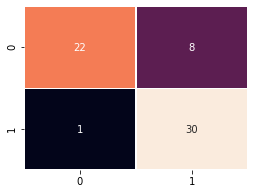

In [23]:
y_pred = best_rf.predict(X_test)

print("Test set accuracy: {:.3f}".format(best_rf.score(X_test, y_test)))

plt.figure(figsize = (4, 3))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, linecolor='white', linewidths=0.5, cbar = False)
ax.set_title('Confusion Matrix'); 
plt.savefig('cm_rf.png', bbox_inches = 'tight', pad_inches = 0.07)

The scores showed in the below plot are the importance scores for each of the variables considered in our model that add up to 1. As it can be noted from the result values, some features do not contribute with any importance to the model, or its importance is extremely low. Therefore, we have decided to simplify our model by performing feature selection and avoid including in the model those variables that do not contribute to it.

We have used the `SelectFromModel` built-in function that uses the best random forest classifier to identify features that have an importance of more than 0.03. With this cutoff we retain in the 8 most important features. Overall, the reduced feature model has no relative accuracy increment compared with the full feature model, however the amount of data used for the prediction has been reduced significantly including only 8 features in the model. In our case, run-time is inconsequential because of the small size of the data set, but in bigger datasets, this trade-off likely would be worth it.

('age', 0.07299482574797893)
('sex', 0.023758443610991543)
('restbp', 0.06420289418182117)
('chol', 0.07721196891514849)
('fbs', 0.009658951590907957)
('thalach', 0.10877539607559751)
('exang', 0.0518916705949265)
('oldpeak', 0.09178754905849881)
('ca', 0.09026621193933076)
('cp_0', 0.09303143498874611)
('cp_1', 0.009660854289744851)
('cp_2', 0.029089363535769252)
('cp_3', 0.010038891566734306)
('restecg_0', 0.016927825705735297)
('restecg_1', 0.017160382169860353)
('restecg_2', 0.0011671520516941965)
('slope_0', 0.005648466442835478)
('slope_1', 0.019357023666599357)
('slope_2', 0.03683863969577041)
('thal_0', 0.0015546246343176476)
('thal_1', 0.00782002112501979)
('thal_2', 0.09519508029612271)
('thal_3', 0.06596232811584866)


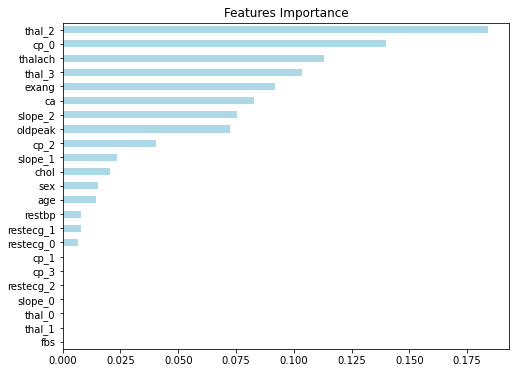

In [24]:
plt.figure(figsize=(8, 6))
importances = pd.Series(data=best_rf.feature_importances_, index=X_train.columns)
importances_sorted = importances.sort_values()
importances_sorted.plot(kind='barh',color='lightblue')
plt.title('Features Importance')
plt.savefig('var_imp_rf.png', bbox_inches = 'tight', pad_inches = 0.07)

feat_labels = X_train.columns
# Print the name and gini importance of each feature
for feature in zip(feat_labels, rf.feature_importances_):
    print(feature)

#### Identify And Select Most Important Features

In [25]:
from sklearn.feature_selection import SelectFromModel

In [26]:
# Selector that will use the random forest classifier to identify features that have 
# an importance of more than the threshold 
# (0.08 keeps the accuracy while reducing the number of variables required in the model to 6)

sfm = SelectFromModel(best_rf, threshold=0.08)

# Train the selector
sfm.fit(X_train, y_train)

# Print the most important features
c=0
for i in sfm.get_support(indices=True):
    c+=1
    print(feat_labels[i])
print("Features selected :",c)

thalach
exang
ca
cp_0
thal_2
thal_3
Features selected : 6


In [27]:
# Transform the data to create a new dataset containing only the most important features. 
# We apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

# Create a new random forest classifier for the most important features
best_rf_im = RandomForestClassifier(bootstrap=False, max_features='log2',
                       min_samples_leaf=10, n_estimators=50, random_state=177)

# Train the new classifier on the new dataset containing the most important features
best_rf_im.fit(X_important_train, y_train)

# Apply The Featured Selected Classifier To The Test Data
y_important_pred = best_rf_im.predict(X_important_test)

# View The Accuracy Of Our Full Feature Model
print("Test set accuracy: {:.5f}, with {} features included in the model.".format(best_rf.score(X_test, y_test),
                                                                           len(X_train.columns)))
# View The Accuracy Of Our Limited Feature Model
accuracy_score(y_test, y_important_pred)
print("Test set accuracy: {:.5f}, with {} features included in the model.".format(best_rf_im.score(X_important_test,y_test),c))

Test set accuracy: 0.85246, with 23 features included in the model.
Test set accuracy: 0.85246, with 6 features included in the model.


***
### Boosting<a class="anchor" id="eigth-bullet"></a>

In this section we will build the model based on two of the most popular boosting algorithms, Gradient Boosting and AdaBoost.
The technique of Boosting uses various loss functions. In case of AdaBoost, it minimises the exponential loss function which can make the algorithm sensitive to the outliers. With Gradient Boosting, any differentiable loss function can be utilised. 

Although there are some differences between the two boosting methods, both the algorithms follow a similar procedure. Both algorithms improve the performance of simple weak learners by repeatedly shifting their focus to problematic observations that are difficult to predict. 

#### AdaBoost<a class="anchor" id="nine-bullet"></a>

In [28]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

Firstly, an AdaBost classification model is  built  without  imputing  any  hyperparameter.


In [29]:
dt = DecisionTreeClassifier(max_depth = 3, random_state=1)
ada = AdaBoostClassifier(base_estimator=dt, random_state=2)
ada.fit(X_train, y_train)

print("Test set accuracy: {:.3f}".format(ada.score(X_test,y_test)))

Test set accuracy: 0.787


This model performs with a 78.7\% test accuracy. Similarly, as in previous section, the model is optimized by performing Grid Search. With the tuning of the hyperparameters illustrated in the code below, the AdaBoost classifier accomplishes an increased accuracy of 82\%, which gets close to the best performance achieved so far by the improved random forest classifier.

In [30]:
# Optimization
params_ada = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5, 1]
}

grid_ada = GridSearchCV(estimator=ada,
                      param_grid=params_ada, 
                      scoring='f1',
                      cv=5,
                      n_jobs=-1)

grid_ada.fit(X_train, y_train)

best_ada = grid_ada.best_estimator_

y_pred = best_ada.predict(X_test)

print("Test set accuracy: {:.3f}".format(best_ada.score(X_test, y_test))) # Better than tree 

Test set accuracy: 0.820


In [31]:
best_ada

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=1),
                   learning_rate=1, n_estimators=100, random_state=2)

('age', 0.13172216343006551)
('sex', 0.020815680571074538)
('restbp', 0.11717437014704102)
('chol', 0.18661748501193043)
('fbs', 0.013587932402366422)
('thalach', 0.163984001012637)
('exang', 0.024952011028124013)
('oldpeak', 0.11763861084372702)
('ca', 0.0784706401038367)
('cp_0', 0.010384777093209459)
('cp_1', 0.018301374958839087)
('cp_2', 0.01689752462355532)
('cp_3', 0.008356930693369485)
('restecg_0', 0.006489664728704905)
('restecg_1', 0.012650685373901446)
('restecg_2', 0.0)
('slope_0', 0.005715246126633004)
('slope_1', 0.009411415254430571)
('slope_2', 0.010202268306161687)
('thal_0', 0.0004632140437601835)
('thal_1', 0.007687903172289543)
('thal_2', 0.024054762032079152)
('thal_3', 0.014421339042263425)


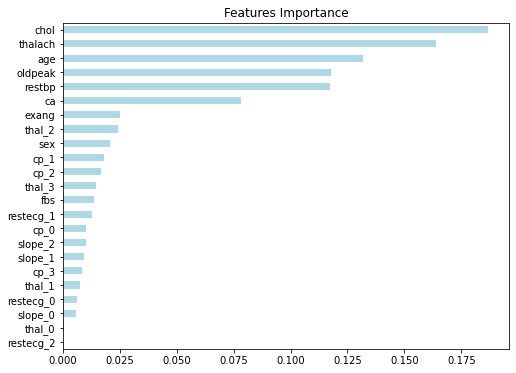

In [32]:
# Feature importance

plt.figure(figsize=(8, 6))
importances = pd.Series(data=best_ada.feature_importances_, index=X_train.columns)
importances_sorted = importances.sort_values()
importances_sorted.plot(kind='barh',color='lightblue')
plt.title('Features Importance')
plt.savefig('var_imp_rf.png', bbox_inches = 'tight', pad_inches = 0.07)

# Print the name and gini importance of each feature
for feature in zip(feat_labels, best_ada.feature_importances_):
    print(feature)

#### Identify And Select Most Important Features

In [33]:
# Selector that will use the AdaBoost classifier to identify features that have 
# an importance of more than the threshold 
# (0.01 improves the accuracy while reducing the number of variables required in the model to 16)



sfm = SelectFromModel(best_ada, threshold=0.01)

# Train the selector
sfm.fit(X_train, y_train)

# Print the most important features
c=0
for i in sfm.get_support(indices=True):
    c+=1
    print(feat_labels[i])
print("Features selected :",c)

# Transform the data to create a new dataset containing only the most important features. 
# We apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

# Create a new random forest classifier for the most important features
best_ada_im = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=1),
                   learning_rate=1, n_estimators=100, random_state=2)

# Train the new classifier on the new dataset containing the most important features
best_ada_im.fit(X_important_train, y_train)

# Apply The Featured Classifier To The Test Data
y_important_pred = best_ada_im.predict(X_important_test)

# View The Accuracy Of Our Limited Feature Model
accuracy_score(y_test, y_important_pred)
print("Test set accuracy: {:.5f}, with {} features included in the model.".format(best_ada_im.score(X_important_test,y_test),c))

age
sex
restbp
chol
fbs
thalach
exang
oldpeak
ca
cp_0
cp_1
cp_2
restecg_1
slope_2
thal_2
thal_3
Features selected : 16
Test set accuracy: 0.85246, with 16 features included in the model.


By selecting the most relevant parameters to fit the model we have improved the performance obtaining an accuracy of 85.2%.

#### Gradient Boosting<a class="anchor" id="ten-bullet"></a>

For Gradient Boosting classification a model without any hyperparameter tuning is built, which accomplishes a test accuracy of 80.3\%. By means of Grid Search optimization no improvement in the accuracy has been achieved. 

In [34]:
from sklearn.ensemble import GradientBoostingClassifier

In [35]:
gb = GradientBoostingClassifier(random_state=1)
gb.fit(X_train, y_train)

print("Test set accuracy: {:.3f}".format(gb.score(X_test,y_test)))

Test set accuracy: 0.803


In [36]:
# Optimization
params_gb = {'loss':['deviance', 'exponential'],
            'learning_rate':[0.01, 0.1, 1],
            'n_estimators':[100, 300, 500], 
            'criterion':['friedman_mse', 'mse'],
            'max_depth':[2,3,4,5],
            'max_features':['auto', 'sqrt', 'log2'],
            'min_samples_split':[2,3,4],
            'min_samples_leaf':[1,2,3]}

params_gb_2 = {'loss':['deviance'],
            'learning_rate':[0.005, 0.01],
            'n_estimators':[100], 
            'criterion':['friedman_mse'],
            'max_depth':[3],
            'max_features':['auto'],
            'min_samples_split':[1, 2],
            'min_samples_leaf':[1, 2]}

grid_gb = GridSearchCV(estimator=gb,
                      param_grid=params_gb_2, 
                      scoring='accuracy',
                      cv=4,
                      n_jobs=-1)

grid_gb.fit(X_train, y_train)

best_gb = grid_gb.best_estimator_

In [37]:
best_gb

GradientBoostingClassifier(learning_rate=0.01, max_features='auto',
                           random_state=1)

In [38]:
best_gb.fit(X_train, y_train)

y_pred = best_gb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy with best GB classifier: {:.3f}".format(accuracy))

Test set accuracy with best GB classifier: 0.803


In [39]:
# Selector that will use the GB classifier to identify features with a cutoff of 0.01 importance.
sfm = SelectFromModel(best_gb, threshold=0.01)

# Train the selector
sfm.fit(X_train, y_train)

# Print the most important features
c=0
for i in sfm.get_support(indices=True):
    c+=1
    print(feat_labels[i])
print("Features selected :",c)

# Transform the data to create a new dataset containing only the most important features. 
# We apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

# Create a new random forest classifier for the most important features
best_gb_im = GradientBoostingClassifier(learning_rate=0.01, max_features='auto',
                           random_state=1)

# Train the new classifier on the new dataset containing the most important features
best_gb_im.fit(X_important_train, y_train)

# Apply The Featured Classifier To The Test Data
y_important_pred = best_gb_im.predict(X_important_test)

# View The Accuracy Of Our Limited Feature Model
accuracy_score(y_test, y_important_pred)
print("Test set accuracy: {:.5f}, with {} features included in the model.".format(best_gb_im.score(X_important_test,y_test),c))

# No improvment in accuracy, but simplifies the model.

restbp
chol
thalach
exang
oldpeak
ca
cp_0
cp_3
slope_2
thal_2
thal_3
Features selected : 11
Test set accuracy: 0.80328, with 11 features included in the model.


***
### XGBoost<a class="anchor" id="eleven-bullet"></a>

In [40]:
import xgboost as xgb

Extreme Gradient Boosting models can be implemented by means of `xgboost` API, which has a similar method and attribute implementations as `sklearn`. An XGBoost classification model is firstly built without tuning any hyperparameter. Here, `early_stopping_rounds` is set to 10 to avoid building tress when they no longer improve the predictions. Besides, the `eval_metric` parameter is set to `'logloss` to use the `negative log likelihood` as loss function, from which the gradients will be computed. 

In [41]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=None, seed=1717)
clf_xgb.fit(X_train, 
            y_train,
            verbose=0,
            early_stopping_rounds=10,     # To stop building trees when they no longer improve the situation
            eval_metric='logloss',
            eval_set=[(X_test, y_test)])  # Evaluating how many trees to build using the test set

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              random_state=1717, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=1717, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [42]:
y_pred = clf_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.836


This model performs with a 83.6\% test accuracy, which approximates to the maximum accuracy achieved so far, which corresponded to the optimized random forest. Optimization of this model can also be carried out by performing Grid Search. 

In [43]:
### Optimization
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.5],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0],
    'scale_pos_weight': [1, 3, 5]
}

## OUTPUT:  gamma=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, reg_lambda=10.0, scale_pos_weight=1

# SECOND ROUND: explore larger or lower values
param_grid_2 = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'gamma': [1, 2, 3],
    'reg_lambda': [2.0, 5.0, 10.0],
    'scale_pos_weight': [1]
}
## OUTPUT: gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_lambda=10.0, scale_pos_weight=1

In [44]:
## To speed up cross validation, and to further prevent overfitting only a random subset of the data (90%) 
## is being used. Also a random subset of columns is used per tree (70%).
optimal_params = GridSearchCV(
    estimator = xgb.XGBClassifier(objective='binary:logistic',
                                  seed=1717,
                                  subsample=0.9,
                                  colsample_bytree=0.7),
    param_grid = param_grid_2,
    scoring = 'accuracy',
    verbose=0,
    n_jobs=-1,
    cv=3
)
optimal_params.fit(X_train, 
                   y_train,
                   early_stopping_rounds = 10,
                   eval_metric = 'logloss',
                   eval_set = [(X_test, y_test)],
                   verbose=0)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.7, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=1717,
                                     subsample=0.9, tree_metho

The final hyperparameters are depicted in the code below, in which we also specify `subsample = 0.9` to use a random subset of data (90\%) used for every tree and `colsample_bytree=0.7` to use a random subset o columns. These parameters, besides speeding up the process of training, also prevent overfitting. 

In [45]:
# best_xgb = optimal_params.best_estimator_
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                            gamma=1, 
                            learning_rate=0.05,
                            max_depth=5,
                            reg_lambda=10,
                            scale_pos_weight=1, 
                            n_estimators = 100,
                            subsample = 0.9,
                            colsample_bytree = 0.7,
                            seed=1717)
clf_xgb.fit(X_train, 
            y_train,
            verbose=0,
            early_stopping_rounds=10,
            eval_metric='logloss',
            eval_set=[(X_test, y_test)])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              random_state=1717, reg_alpha=0, reg_lambda=10, scale_pos_weight=1,
              seed=1717, subsample=0.9, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [46]:
y_pred = clf_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.852


With  this improved  configuration of  hyperparameters,  the  XGB  classifier  accomplishes  a  85.2\% accuracy score.  As shown in the confusion matrix, it can be appreciated that the classifier only returns 1 false negative and 8 false positives. Regarding the feature importance plot illustrated above, it can be appreciated that 6 variables are not considered when building the tree, and `thal_2`, which corresponds to \textit{fixed defect} on thalium heart scan, it the most important variable to split the nodes. This importance is also observed in the previous models. 

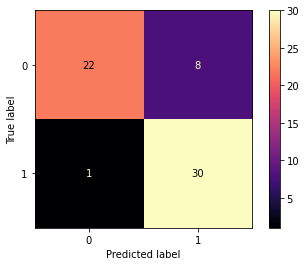

In [47]:
plot_confusion_matrix(clf_xgb, X_test, y_test, values_format='d', cmap='magma')

('age', 0.02174318)
('sex', 0.025122391)
('restbp', 0.027077565)
('chol', 0.025294766)
('fbs', 0.0)
('thalach', 0.036817264)
('exang', 0.05057378)
('oldpeak', 0.043170854)
('ca', 0.08725821)
('cp_0', 0.15562318)
('cp_1', 0.020845393)
('cp_2', 0.048083723)
('cp_3', 0.040274385)
('restecg_0', 0.022418607)
('restecg_1', 0.028874474)
('restecg_2', 0.0)
('slope_0', 0.0)
('slope_1', 0.03319186)
('slope_2', 0.035759505)
('thal_0', 0.0)
('thal_1', 0.0)
('thal_2', 0.24651007)
('thal_3', 0.051360756)


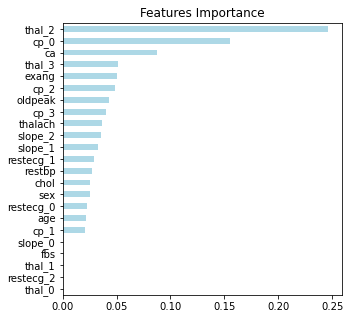

In [48]:
# Feature importance
plt.figure(figsize=(5, 5))
importances = pd.Series(data=clf_xgb.feature_importances_, index=X_train.columns)
importances_sorted = importances.sort_values()
importances_sorted.plot(kind='barh',color='lightblue')
plt.title('Features Importance')

# Print the name and gini importance of each feature
for feature in zip(feat_labels, clf_xgb.feature_importances_):
    print(feature)

#### Identify And Select Most Important Features

In [49]:
# Selector that will use the XGB classifier to identify features with a cutoff of 0.01 importance.
sfm = SelectFromModel(clf_xgb, threshold=0.05)

# Train the selector
sfm.fit(X_train, y_train)

# Print the most important features
c=0
for i in sfm.get_support(indices=True):
    c+=1
    print(feat_labels[i])
print("Features selected :",c)

# Transform the data to create a new dataset containing only the most important features. 
# We apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

# Create a new random forest classifier for the most important features
clf_xgb_im = xgb.XGBClassifier(objective='binary:logistic',
                            gamma=1, 
                            learning_rate=0.05,
                            max_depth=5,
                            reg_lambda=10,
                            scale_pos_weight=1, 
                            n_estimators = 100,
                            subsample = 0.9,
                            colsample_bytree = 0.7,
                            seed=1717)

# Train the new classifier on the new dataset containing the most important features
clf_xgb_im.fit(X_important_train, 
            y_train,
            verbose=0,
            early_stopping_rounds=10,
            eval_metric='logloss',
            eval_set=[(X_important_test, y_test)])

# Apply The Featured Classifier To The Test Data
y_important_pred = clf_xgb_im.predict(X_important_test)

# View The Accuracy Of Our Limited Feature Model
accuracy_score(y_test, y_important_pred)
print("Test set accuracy: {:.5f}, with {} features included in the model.".format(clf_xgb_im.score(X_important_test,y_test),c))

# No improvment in accuracy, but simplifies the model.

[17:54:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614844528294/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
exang
ca
cp_0
thal_2
thal_3
Features selected : 5
Test set accuracy: 0.85246, with 5 features included in the model.


***

## Conclusions<a class="anchor" id="lat-bullet"></a>

Ensemble algorithms, especially those that use decision trees as weak learners, have multiple advantages over other machine learning methods.
These algorithms are non-parametric and thus they do not assume or require the data to follow a specific distribution, saving time of transforming the original dataset by an exhaustive preprocessing of scaling and normalizing data. They are also robust against overfitting. As a result of using many weak learners that underfit (high bias) and combine those predictions into a stronger learner, the variance of the model is reduced.

Another advantage of tree-based methods is that feature multicollinearity does not affect the accuracy and predictive performance of the models. Therefore, there is no need to delete features or perform feature engineering to reduce the correlation and interaction between them.

Robustness against outliers and noisy data is relatively well achieved by means of these methods. Usually, they will deal with noisy data (e.g. features that have no effect on the target) or outliers (e.g. extreme values), with little impact on overall performance.

Regarding the results of the accuracy obtained by all of our built models shown, Random Forest and Boosting algorithms perform much better than their weak learners. 

**Decision trees** are the least accurate, performing with a 78.7\% accuracy, due to their high variance/overfitting compared with the other classifier algorithms used to built the models. 

Followed by **Gradient Boost**, which uses boosting method to combine individual decision trees, the accuracy is increased up to 80.3\%. 

Hyperparemetes are key parts of learning algorithms which effect the performance and accuracy of a model. Two critical hyperparameters for gradient boosting are the *learning rate* and *n\_estimators*. Each added tree modifies the overall model, and by means of the learning rate parameter the magnitude of the modification is controlled. Models that learns slow tend to have a better performance, however,  this has a computational cost on time and on the increment of trees needed in the model *(n\_estimators)*. This also has a risk of overfitting if too many trees are used. In our model no increment in accuracy has been obtained by means of optimization when tuning the hyperparameters of this classifier. 

The results for the three remaining classifiers are tied with an accuracy of 85.2\%.


**AdaBoost** results show that it performs worse when irrelevant features are included in the model, improving its accuracy when only relevant important features are retained. This algorithm has only few hyperparameters that need to be tuned to improve model performance. AdaBoost is not optimized for speed, therefore being significantly slower than other classifiers. 

**Random Forest** have some advantages over AdaBoost, since it is less affected by noise and it generalizes better reducing variance, and its speed is enhanced thanks to the parallel ensembling. Nevertheless, this algorithm requires more hyperparameter tuning because of a higher number of relevant parameters.

For the last classifier **XGBoost**, which is a relatively new algorithm introduced in 2016 that uses the concept of gradient tree boosting, its main advantage is the lightning speed<sup>\*1</sup>  compared to the other algorithms, and its regularization parameter that successfully reduces variance. In addition to the regularization parameter, the algorithm also uses the *learning rate* and *subsamples* of features, thereby further improving its generalization ability. 
Nonetheless, compared with AdaBoost, Gradient Boost, and Random Forest, XGBoost is more difficult to understand and adjust. There are many hyperparameters that can be tuned to increase performance. This classifier is particularly interesting when both speed and high accuracy are of the essence. However, since model adjustment requires more time and user expertise to obtain meaningful results, more resources are needed to train the model. 
Therefore, the decision of when to use which tree-based algorithm depends on the dataset along with the resources available and the user expertise. 

> <sup>\*1</sup> : Since the dataset on which we implemented our models in a relatively small, differences in speed performance could not been appreciated between models.